In [1]:
import torch
import torch.nn as nn
import torch.fft as fft
from torch.utils.data import Dataset

import torchvision
from torchvision.transforms import v2
from torchvision import models
import matplotlib.pyplot as plt

In [2]:
import os
import math
import numpy
from tqdm import tqdm
import cv2
import lmdb
import pickle

In [6]:
def load_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    transform = v2.Compose([
        v2.ToImage(),
        v2.Resize((128, 128))
    ])
    img = transform(img)
    return img

In [7]:
path = os.path.join('image.jpeg')
image = load_image(path)
fft_image = fft.fft2(image, dim=(-2,-1))
fft_shift = fft.fftshift(fft_image, dim=(-2,-1))
# fft_image = fft.fftshift(fft_image, dim=(-2,-1))
magnitude = torch.log(torch.abs(fft_shift)+ 1)

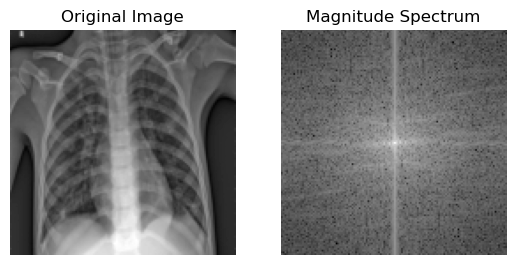

In [9]:
plt.subplot(1,2,1)
plt.title('Original Image')
plt.imshow(image.permute(1,2,0), cmap='gray')
plt.axis('off')

plt.subplot(1,2,2)
plt.title('Magnitude Spectrum')
plt.imshow(magnitude.permute(1,2,0), cmap='gray')
plt.axis('off')
plt.savefig('fft_img.png', dpi=300, bbox_inches='tight')

plt.show()

In [10]:
rows, cols = image.squeeze(0).shape
crow, ccol = rows//2, cols//2
radius = 50

mask = torch.zeros((rows, cols))
y, x = torch.meshgrid(torch.arange(0, rows), torch.arange(0, cols), indexing='ij')
mask_area = torch.sqrt((x - ccol)**2 + (y - crow)**2)

mask_h = (mask_area > radius).float()
mask_l = (mask_area <= radius).float()

In [11]:
high_filtered_fft = fft_shift * mask_h
high_filtered_image = torch.abs(fft.ifftshift(high_filtered_fft))
magnitude_high_filtered_image = torch.log(torch.abs(high_filtered_image)+ 1)

low_filtered_fft = fft_shift * mask_l
low_filtered_image = torch.abs(fft.ifftshift(low_filtered_fft))
magnitude_low_filtered_image = torch.log(torch.abs(low_filtered_image)+ 1)

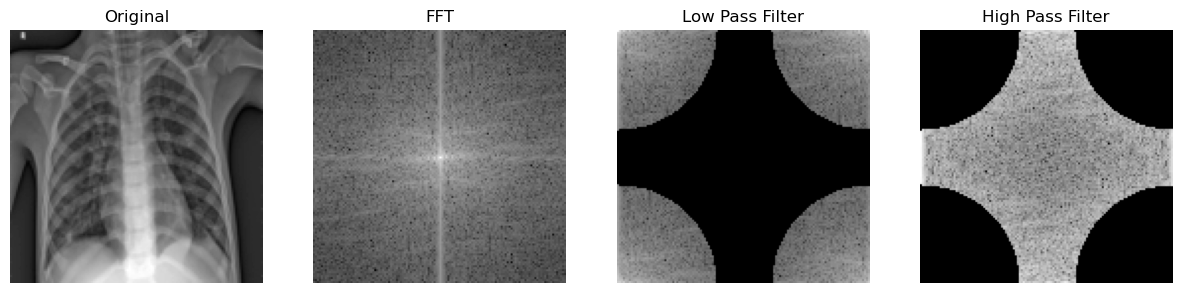

In [13]:
fig, axes = plt.subplots(1, 4, figsize=(15, 5))
axes = axes.flatten()

axes[0].set_title('Original')
axes[0].imshow(image.permute(1,2,0), cmap='gray')
axes[0].axis('off')

axes[1].set_title('FFT')
axes[1].imshow(magnitude.permute(1,2,0), cmap='gray')
axes[1].axis('off')

axes[2].set_title('Low Pass Filter')
axes[2].imshow(magnitude_low_filtered_image.permute(1,2,0), cmap='gray')
axes[2].axis('off')

axes[3].set_title('High Pass Filter')
axes[3].imshow(magnitude_high_filtered_image.permute(1,2,0), cmap='gray')
axes[3].axis('off')

plt.savefig('filter_img.png', dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
model = models.googlenet(weights='GoogLeNet_Weights.DEFAULT')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

In [ ]:
def change_layer(layer):
    fft_conv = FFTConvNet(layer, 'low')
    return fft_conv

In [ ]:
# Check the output channels of the original Conv2d layer
original_conv = model.inception3a.branch2[0].conv
print("Original Conv2d output channels:", original_conv.out_channels)

# Replace the Conv2d layer with FFTConvNet
fft_conv = change_layer(original_conv).to(device)
model.inception3a.branch2[0].conv = fft_conv

# Verify the output channels of the FFTConvNet layer
print("FFTConvNet output channels:", fft_conv.conv_layer.out_channels)

In [ ]:
model = models.alexnet(weights=None)

In [ ]:
model.classifier

In [ ]:
model.features = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(2, 2)),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
    nn.Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
    nn.Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
    nn.ReLU(inplace=True),
    nn.Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
    nn.ReLU(inplace=True),
    nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
)

model.classifier = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(9216, out_features=1024),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5),
    nn.Linear(in_features=1024, out_features=512),
    nn.LeakyReLU(),
    nn.Linear(in_features=512, out_features=3)
)

In [ ]:
model

In [ ]:
dummy_input = torch.randn(1, 3, 227, 227)
outputs = model(dummy_input)
print("Outputs: ", outputs)